In [1]:
from gw_signal_tools.inner_product import td_to_fd_waveform, fd_to_td_waveform, pad_to_get_target_df, restrict_f_range

import astropy.units as u
import lalsimulation.gwsignal.core.waveform as wfm
import numpy as np
import matplotlib.pyplot as plt

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


# Waveform Conversion Verifications

First we need an example signal

In [2]:
# Define the dictionary
deltaT = 1./1024.*u.s  # Has no influence on accuracy, higher one just looks smoother
# deltaT = 1./2048.*u.s
# deltaT = 1./4096.*u.s
f_min = 20.*u.Hz  # Cutoff frequency
f_ref = 20.*u.Hz  # Frequency where we specify spins
distance = 440.*u.Mpc
inclination = 2.7*u.rad  # Value taken from posteriors.ipynb, where posterior of inclination is plotted
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad


parameters_gw150914 = {
    'mass1' : 36*u.solMass,
    'mass2' : 29*u.solMass,
    'deltaT' : deltaT,
    'f22_start' : f_min,
    'f22_ref': f_ref,
    'phi_ref' : phiRef,
    'distance' : distance,
    'inclination' : inclination,
    'eccentricity' : eccentricity,
    'longAscNodes' : longAscNodes,
    'meanPerAno' : meanPerAno,
    'condition' : 0
}

# Define the approximant
approximant = 'IMRPhenomXPHM'

# Call the generator
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


# Generate waveform -> output are two time series, h_plus and h_cross
hp_t, _ = wfm.GenerateTDWaveform(parameters_gw150914, gen)

# Two waveforms will be generated in frequency domain, first with finer
# sampling and then with coarser one
hp_f_fine, _ = wfm.GenerateFDWaveform(parameters_gw150914, gen)

hp_f_coarse, _ = wfm.GenerateFDWaveform(parameters_gw150914 | {'deltaF': 1.0 / (hp_t.size * hp_t.dx)}, gen)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


## Sanity Checks

Transforming to one domain and back must yield the same waveform, up to essentially numerical precision

### Frequency Domain

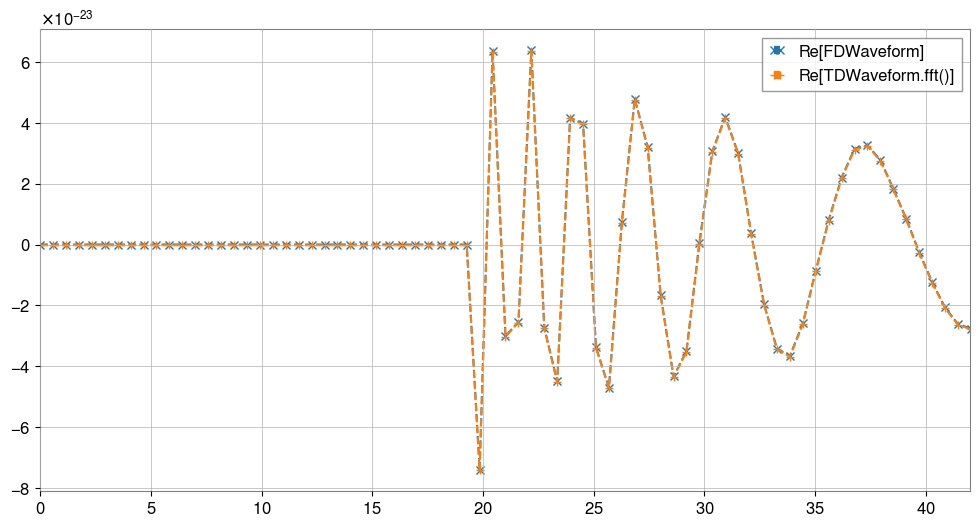

In [3]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_coarse), 'x--', label='Re[FDWaveform]')

ax.plot(np.real(td_to_fd_waveform(fd_to_td_waveform(hp_f_coarse))), '+--', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

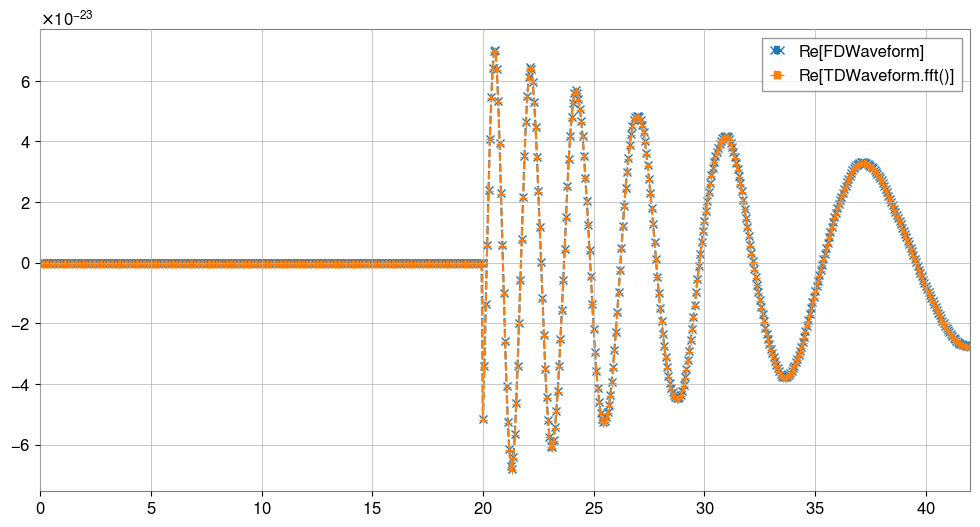

In [4]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_fine), 'x--', label='Re[FDWaveform]')

ax.plot(np.real(td_to_fd_waveform(fd_to_td_waveform(hp_f_fine))), '+--', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

In [5]:
print(np.all(np.isclose(hp_f_fine, td_to_fd_waveform(fd_to_td_waveform(hp_f_fine)), rtol=0.001)))

True


In [6]:
print(np.all(np.isclose(hp_f_coarse, td_to_fd_waveform(fd_to_td_waveform(hp_f_coarse)), rtol=0.001)))

True


Equal up to at least 0.1%

For a visual proof of that we plot the absolute differences

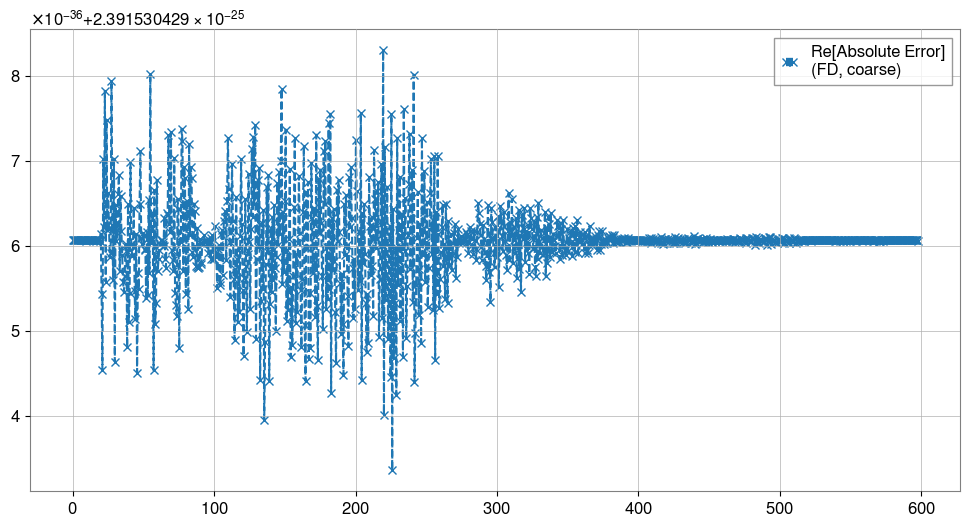

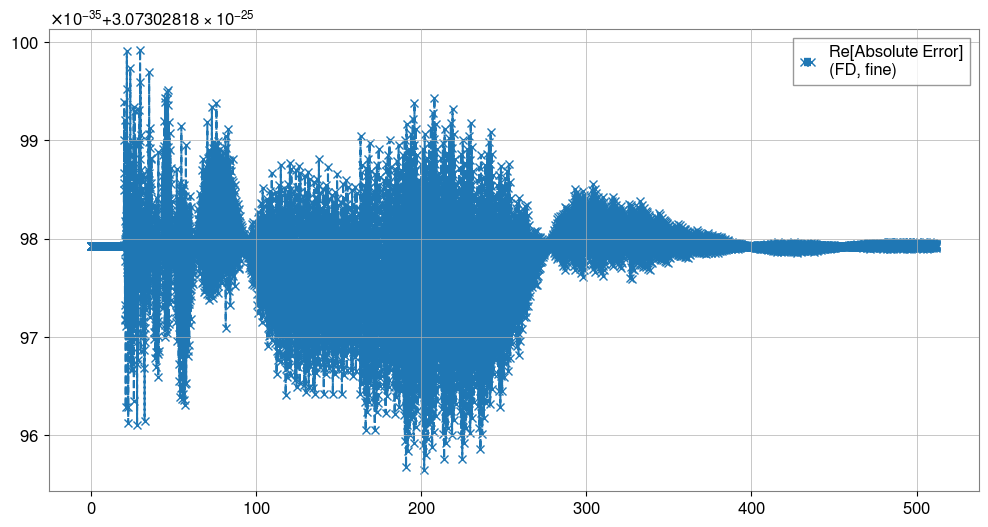

In [7]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_coarse - td_to_fd_waveform(fd_to_td_waveform(hp_f_coarse))), 'x--', label='Re[Absolute Error]\n(FD, coarse)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()



f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_fine - td_to_fd_waveform(fd_to_td_waveform(hp_f_fine))), 'x--', label='Re[Absolute Error]\n(FD, fine)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

These are essentially random errors, especially for first plot one can see no systematic in error signal

### Time Domain

In [8]:
hp_t_fft_ifft = fd_to_td_waveform(td_to_fd_waveform(hp_t))

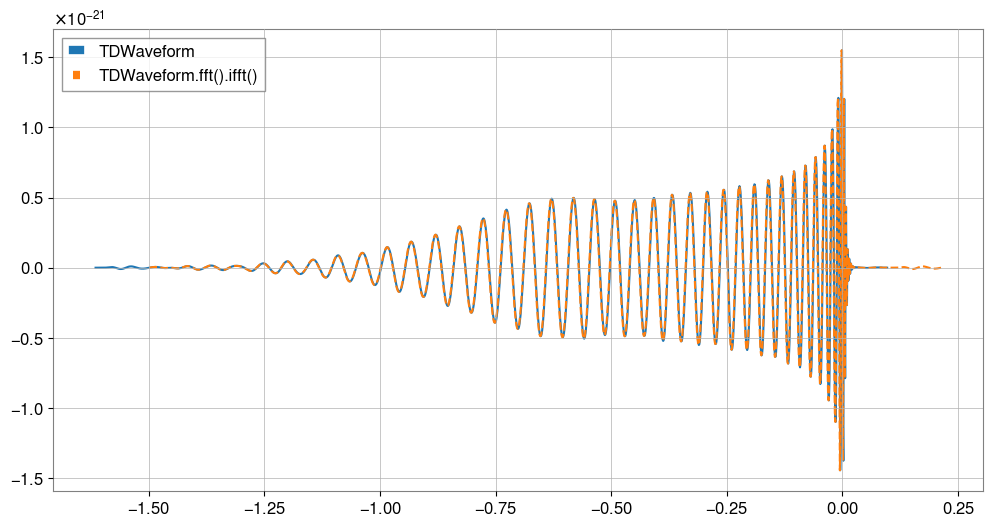

In [9]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_t_fft_ifft, '--', label='TDWaveform.fft().ifft()')

ax.legend()

# ax.set_xlim([-1.5, 0.5])
# ax.set_xlim([-0.1, 0.025])

plt.show()

Very good, apart from different end and start points everything is equal.

This must not change for smaller df.

In [10]:
hp_t_fft_ifft_fine = fd_to_td_waveform(td_to_fd_waveform(pad_to_get_target_df(hp_t, df=0.0625 * u.Hz)))

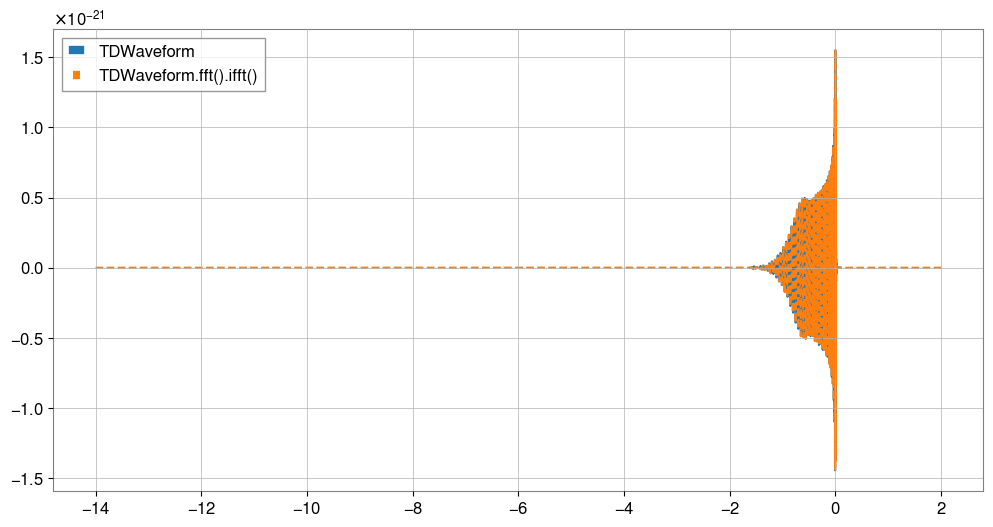

In [11]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_t_fft_ifft_fine, '--', label='TDWaveform.fft().ifft()')

ax.legend()

# ax.set_xlim([-1.5, 0.5])
# ax.set_xlim([-0.1, 0.025])

plt.show()

In [12]:
if hp_t.size % 2 == 0:
    print(np.all(np.isclose(hp_t, hp_t_fft_ifft, rtol=0.001)))
else:
    # Fourier transformation will return even number of samples
    print(np.all(np.isclose(hp_t[:-1], hp_t_fft_ifft, rtol=0.001)))

True


!!! Does this comparison make sense? Because we compare shifted signals... !!!

Equal up to at least 0.1%

## Time Domain to Frequency Domain

- TODO for each: make zoom only in inset

Now we compare how well the FDWaveform generated by lal and our transformed TDWaveform agree

In [13]:
hp_t_f_coarse = td_to_fd_waveform(hp_t)

# For a finer resolution, we have to pad signal
hp_t_padded = pad_to_get_target_df(hp_t, df=hp_f_fine.df)
hp_t_f_fine = td_to_fd_waveform(hp_t_padded)

In [14]:
print(hp_f_coarse.df, hp_t_f_coarse.df)

print(hp_f_fine.df, hp_t_f_fine.df)

0.5838084378563284 Hz 0.5838084378563284 Hz
0.0625 Hz 0.0625 Hz


This demonstrates that `pad_to_get_target_df` does its job

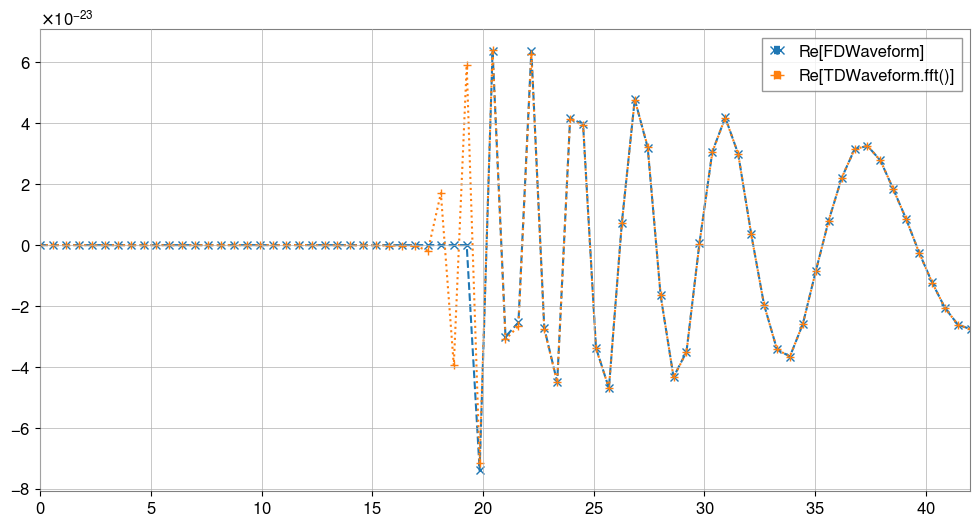

In [15]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_coarse), 'x--', label='Re[FDWaveform]')

ax.plot(np.real(hp_t_f_coarse), '+:', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

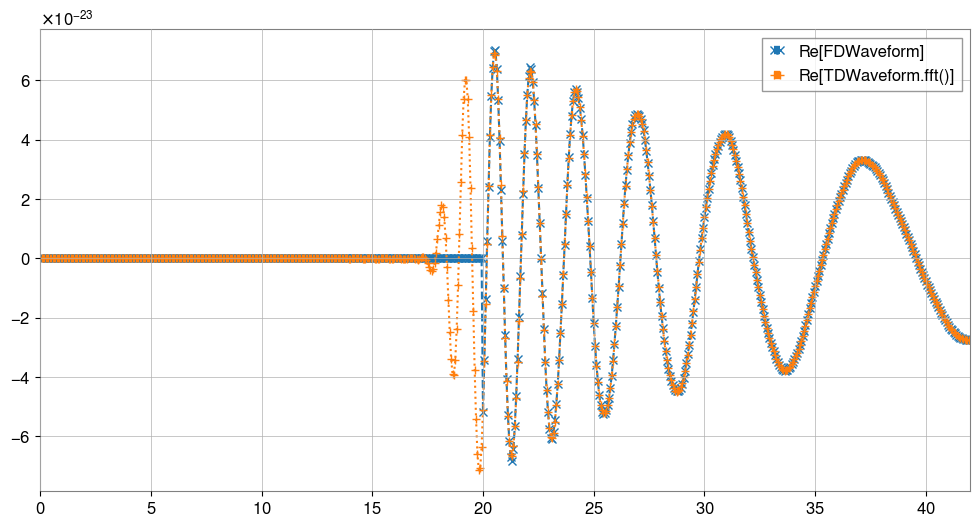

In [16]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_f_fine), 'x--', label='Re[FDWaveform]')

ax.plot(np.real(hp_t_f_fine), '+:', label='Re[TDWaveform.fft()]')

ax.legend()

ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])

plt.show()

In [17]:
# Nyquist of coarse sampling is not as big as end frequency of FDWaveform, have to restrict

# print(np.all(np.isclose(restrict_f_range(hp_f_coarse, f_range=[hp_t_f_coarse.frequencies[0], hp_t_f_coarse.frequencies[-1]]), hp_t_f_coarse, rtol=0.001)))
print(np.all(np.isclose(hp_f_coarse[:hp_t_f_coarse.size], hp_t_f_coarse, rtol=0.001)))

True


In [18]:
if hp_f_fine.size == hp_t_f_fine.size:
    print(np.all(np.isclose(hp_f_fine, hp_t_f_fine, rtol=0.001)))
else:
    print(np.all(np.isclose(hp_f_fine[:-1], hp_t_f_fine, rtol=0.001)))

True


Very good agreement

## Frequency Domain to Time Domain

Now we compare how well the TDWaveform generated by lal and our transformed FDWaveform agree

In [19]:
hp_f_t_coarse = fd_to_td_waveform(hp_f_coarse)
hp_f_t_fine = fd_to_td_waveform(hp_f_fine)

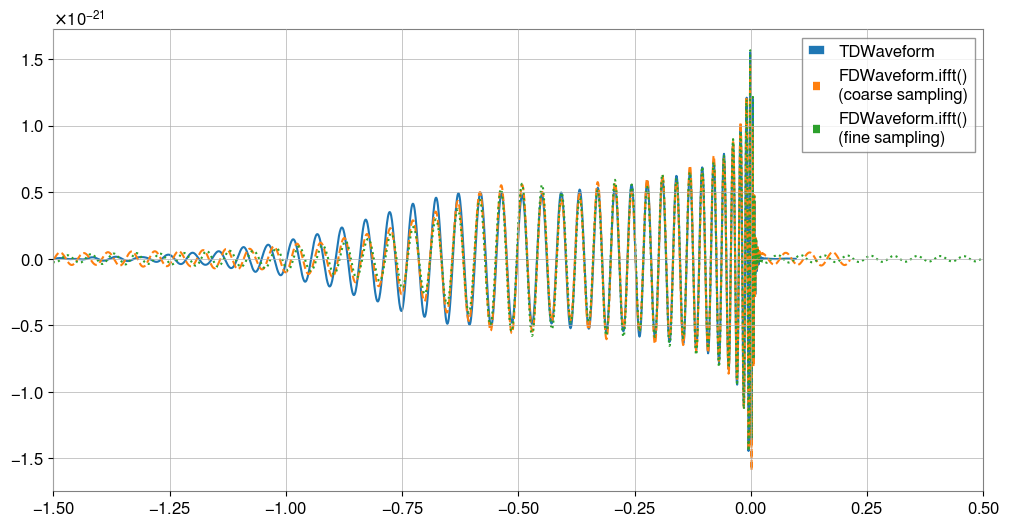

In [20]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_f_t_fine, ':', label='FDWaveform.ifft()\n(fine sampling)')

ax.legend()

ax.set_xlim([-1.5, 0.5])

plt.show()

Close to merger, agreement has to be best

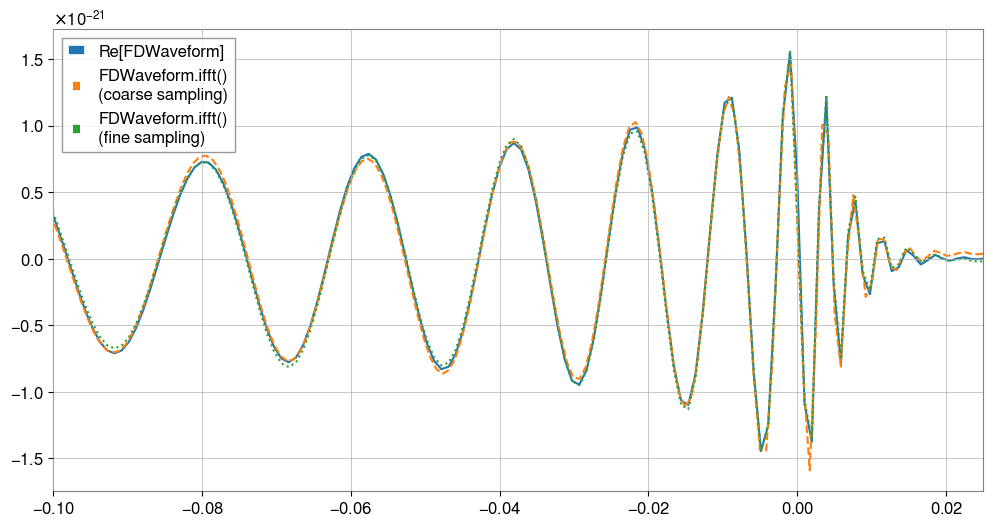

In [21]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='Re[FDWaveform]')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_f_t_fine, ':', label='FDWaveform.ifft()\n(fine sampling)')

ax.legend()

ax.set_xlim([-0.1, 0.025])

plt.show()

Differences between coarse and fine sampling remain, which makes sense. For fine sampling, the results are reasonably equal.

Most of the differences from the plot before are perhaps caused by tapering that we do not apply, but is applied for lal waveform

In [22]:
t_range = [-0.75 * u.s, 0.1 * u.s]  # Chosen manually
print(np.all(np.isclose(hp_t[(hp_t.times >= t_range[0]) & (hp_t.times <= t_range[1])], hp_f_t_coarse[(hp_f_t_coarse.times >= t_range[0]) & (hp_f_t_coarse.times <= t_range[1])][:869 - 1017], rtol=0.001)))
# Note: the -3 for first argument had to be chosen manually because a slightly unequal dt causes hp_t_fine to have three more samples

True


In [23]:
t_range = [-0.75 * u.s, 0.1 * u.s]  # Chosen manually
print(np.all(np.isclose(hp_t[(hp_t.times >= t_range[0]) & (hp_t.times <= t_range[1])], hp_f_t_fine[(hp_f_t_fine.times >= t_range[0]) & (hp_f_t_fine.times <= t_range[1])][:-3], rtol=0.001)))
# Note: the -3 for first argument had to be chosen manually because a slightly unequal dt causes hp_t_fine to have three more samples

True


Good!

## Impact of Tapering

To be examined

Hypothesis: causes slight differences of signals coming out of generator and signals in other domain that are converted using our procedures (tapering changes Fourier components slightly, also morphology in time domain)

## Impact of Filtering

### In Frequency Domain

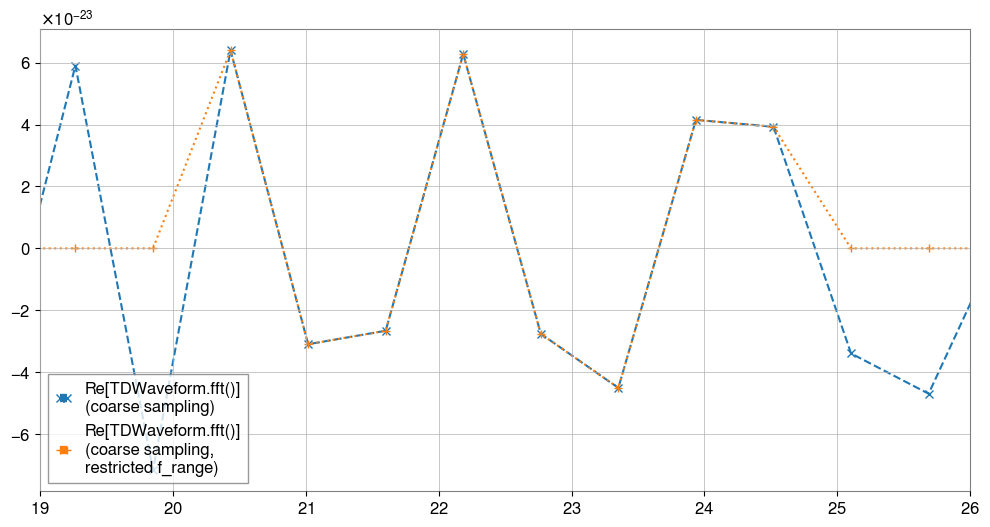

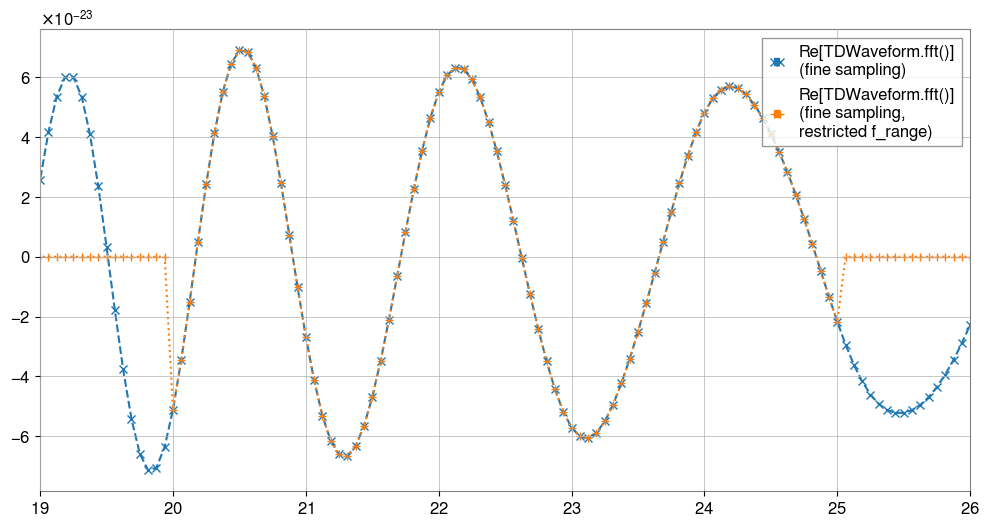

In [31]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_t_f_coarse), 'x--', label='Re[TDWaveform.fft()]\n(coarse sampling)')

ax.plot(np.real(restrict_f_range(hp_t_f_coarse, f_range=[20, 25])), '+:', label='Re[TDWaveform.fft()]\n(coarse sampling,\nrestricted f_range)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])
ax.set_xlim([19.0, 26])

plt.show()


f,ax = plt.subplots(figsize=(12, 6))

ax.plot(np.real(hp_t_f_fine), 'x--', label='Re[TDWaveform.fft()]\n(fine sampling)')

ax.plot(np.real(restrict_f_range(hp_t_f_fine, f_range=[20, 25])), '+:', label='Re[TDWaveform.fft()]\n(fine sampling,\nrestricted f_range)')

ax.legend()

# ax.set_xlim([0.0, 42])
# ax.set_xlim([0.0, 256])
ax.set_xlim([19.0, 26.0])
# ax.set_xlim([19.9, 20.1])

plt.show()

Does exactly what it should do: setting frequency components out of range to zero while leaving other samples untouched

### In Time Domain

In [25]:
hp_t_coarse_filtered = fd_to_td_waveform(hp_t_f_coarse, f_range=[f_min, None])
hp_t_fine_filtered = fd_to_td_waveform(hp_t_f_fine, f_range=[f_min, None])

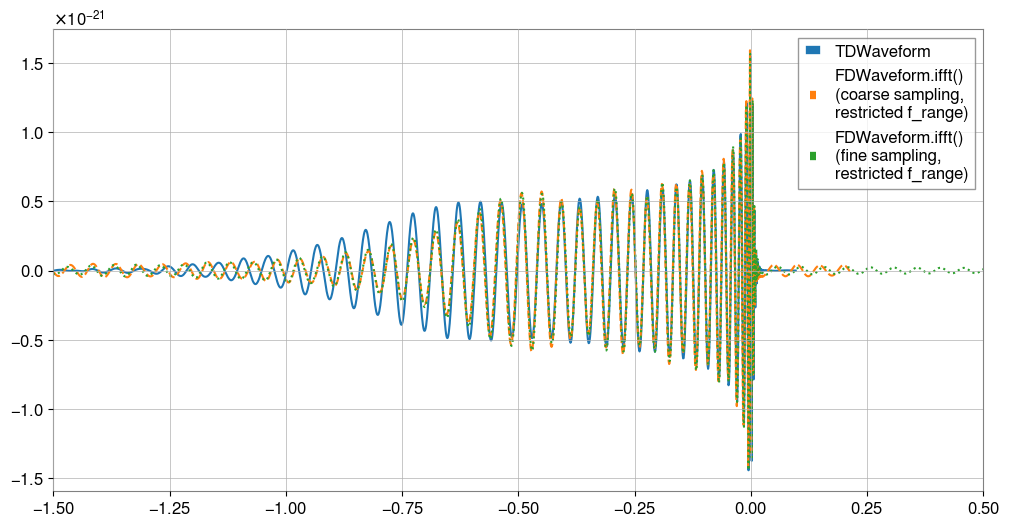

In [26]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_t_coarse_filtered, '--', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend()

ax.set_xlim([-1.5, 0.5])

plt.show()

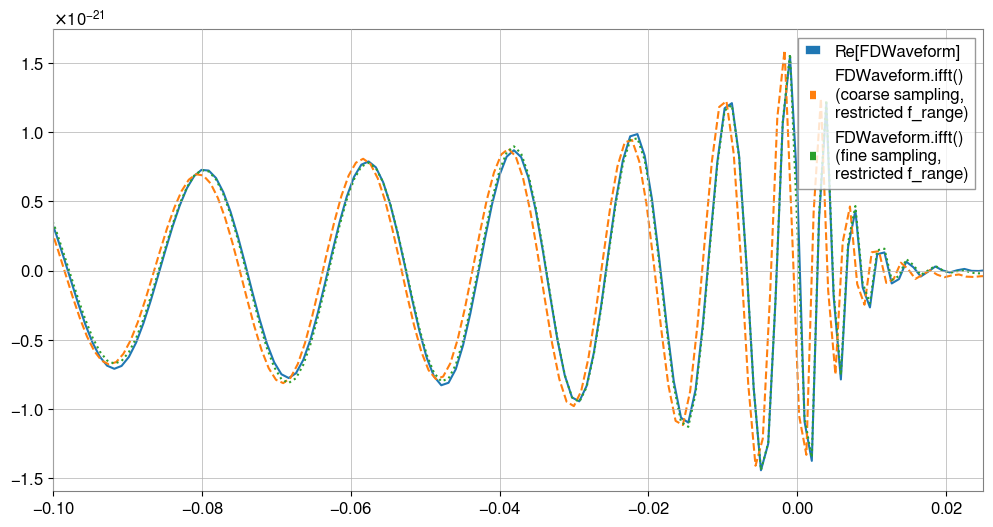

In [27]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='Re[FDWaveform]')

ax.plot(hp_t_coarse_filtered, '--', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend()

ax.set_xlim([-0.1, 0.025])

plt.show()

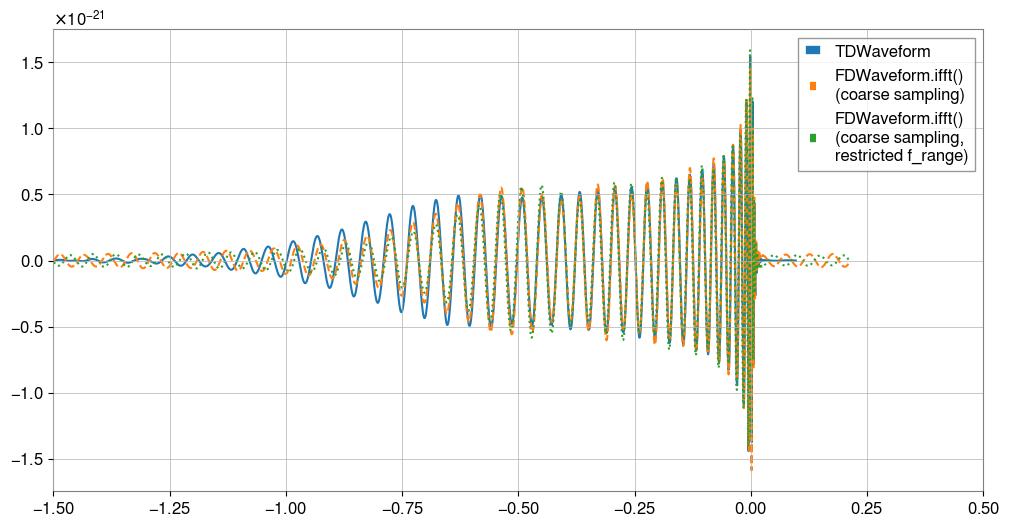

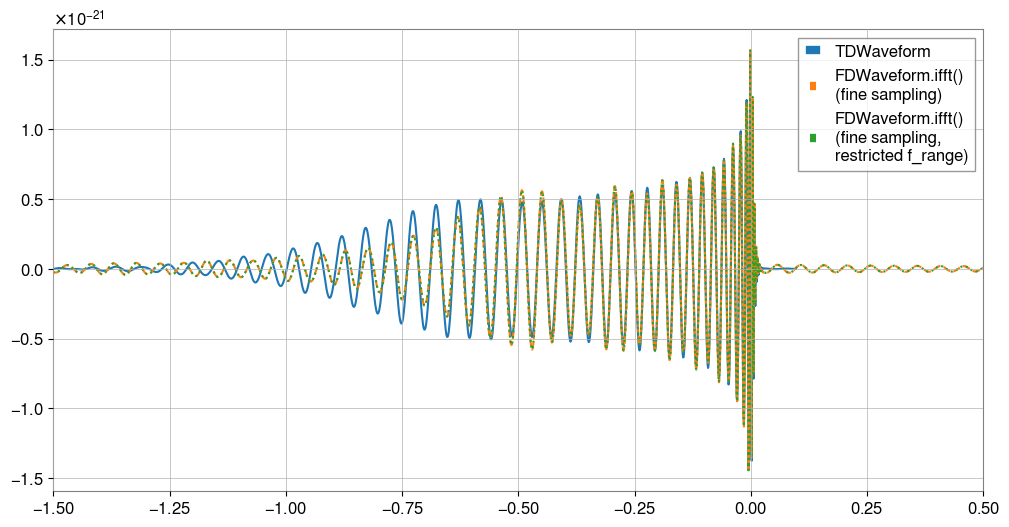

In [28]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_t_coarse_filtered, ':', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.legend()

ax.set_xlim([-1.5, 0.5])

plt.show()



f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_fine, '--', label='FDWaveform.ifft()\n(fine sampling)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend()

ax.set_xlim([-1.5, 0.5])

plt.show()

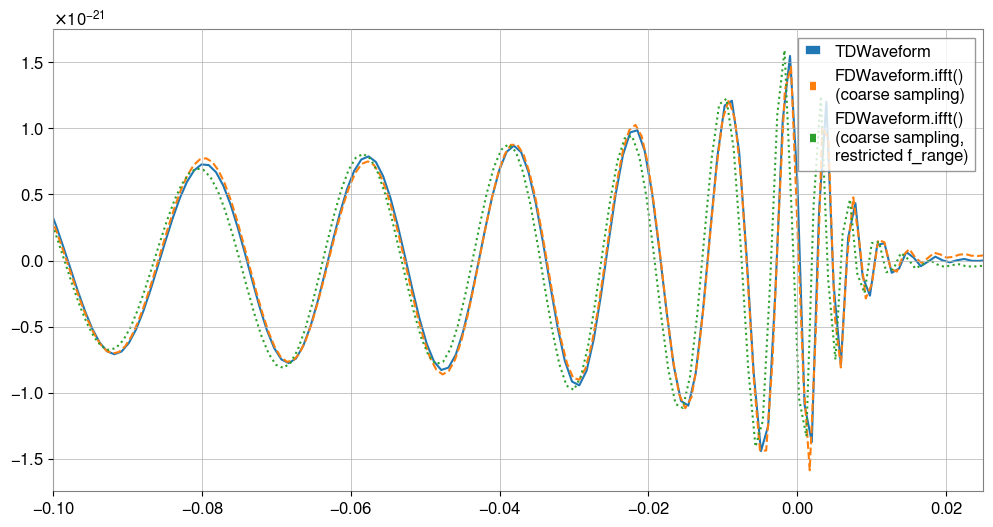

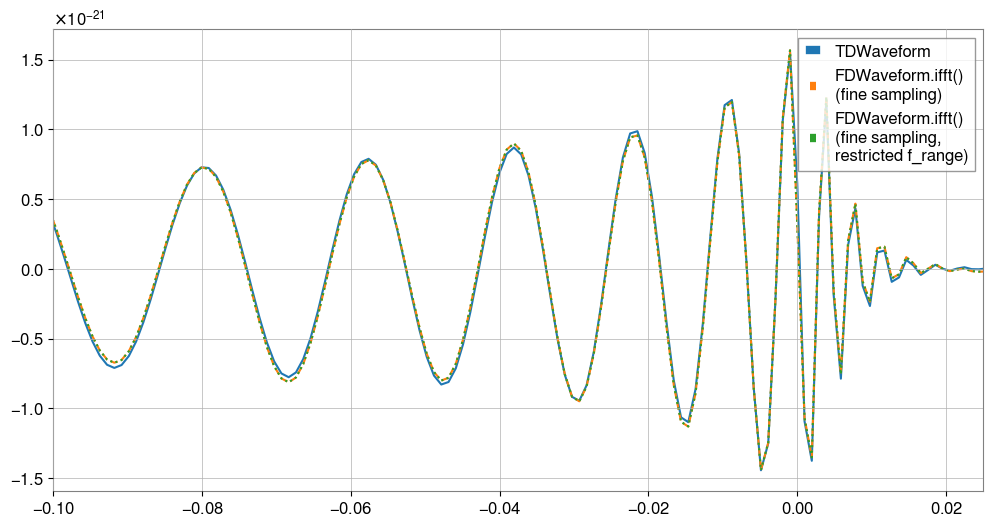

In [29]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_coarse, '--', label='FDWaveform.ifft()\n(coarse sampling)')

ax.plot(hp_t_coarse_filtered, ':', label='FDWaveform.ifft()\n(coarse sampling,\nrestricted f_range)')

ax.legend()

ax.set_xlim([-0.1, 0.025])

plt.show()



f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(hp_f_t_fine, '--', label='FDWaveform.ifft()\n(fine sampling)')

ax.plot(hp_t_fine_filtered, ':', label='FDWaveform.ifft()\n(fine sampling,\nrestricted f_range)')

ax.legend()

ax.set_xlim([-0.1, 0.025])

plt.show()

Clearly, removing some Fourier components and thus information has an impact on the Fourier transform of the coarsely sampled signal. For fine sampling, this impact is negligible.

Generally speaking, filtering also increases the phase shift observed most prominently at the beginning of the signal.

## Impact of Padding

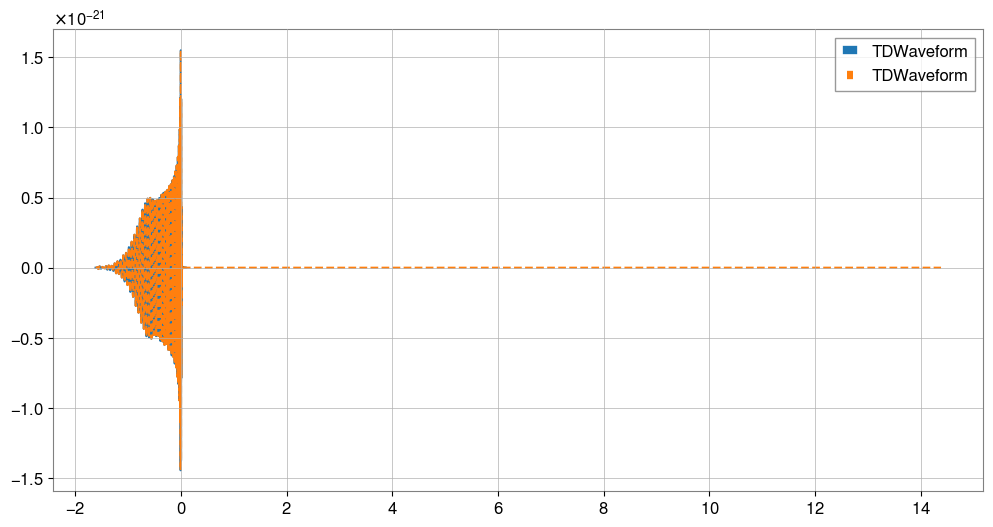

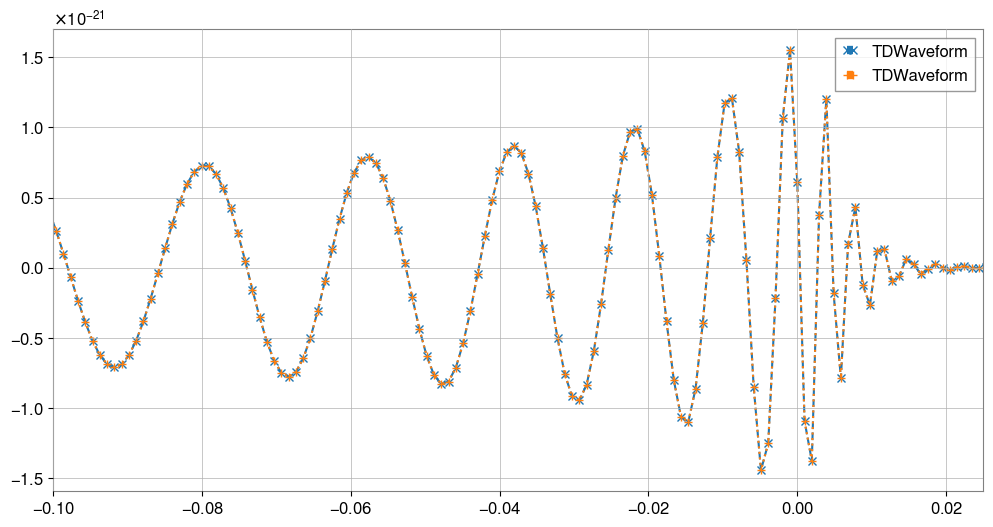

In [30]:
f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, label='TDWaveform')

ax.plot(pad_to_get_target_df(hp_t, df=0.0625 * u.Hz), '--', label='TDWaveform')

ax.legend()

plt.show()



f,ax = plt.subplots(figsize=(12, 6))

ax.plot(hp_t, 'x--', label='TDWaveform')

ax.plot(pad_to_get_target_df(hp_t, df=0.0625), '+:', label='TDWaveform')  # Input without unit works as well

ax.legend()

# ax.set_xlim([-1.5, 0.5])
ax.set_xlim([-0.1, 0.025])

plt.show()

Does exactly what it should do: increasing sample size by adding zeros after end of signal while leaving other samples untouched